In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sax
from simphony.libraries import siepic, sipann
from simphony.classical import ClassicalSim
from functools import partial
import quantp as qp

In [3]:
def pcpl(wl=1.55, phase=0) -> sax.SDict:
    """
    create a directional coupler with a phase shifter
    wl - wavelength in um
    phase - phase shift in radians (in units of 2*pi)
    e.g phase = 0.5 means pi phase shift
    """
    cir, info = sax.circuit(
            netlist={
                "instances": {
                    "stdcpl1":"standard_coupler",
                    "waveg_t": "waveguide",
                    "waveg_b": "waveguide",
                    },
                "connections": {
                    "stdcpl1,o2": "waveg_t,o0",
                    "stdcpl1,o3": "waveg_b,o0",
                    },
                "ports": {
                    "in_t":"stdcpl1,o0",
                    "in_b":"stdcpl1,o1",
                    "out_t":"waveg_t,o1",
                    "out_b":"waveg_b,o1",
                    }
                },
            models={
                "waveguide": partial(siepic.waveguide, width=500, length=10000),
                "standard_coupler":partial(sipann.standard_coupler, length=6363, horizontal=5000, vertical=2500),
                }
                )

    # need to first recover the effective index
    # Return the composite model.
    #deln = 0.000155*phase*2*np.pi*10000/wl
    deln = phase*2*np.pi
    val = cir(wl = wl)
    #print((np.cos(deln) + 1j*np.sin(deln)))
    val[('in_t', 'out_t')] = val[('in_t', 'out_t')] * (np.cos(deln) + 1j*np.sin(deln))
    val[('out_t', 'in_t')] = val[('out_t', 'in_t')] * (np.cos(deln) + 1j*np.sin(deln))
    val[('out_t', 'in_b')] = val[('out_t', 'in_b')] * (np.cos(deln) + 1j*np.sin(deln))
    val[('in_b', 'out_t')] = val[('in_b', 'out_t')] * (np.cos(deln) + 1j*np.sin(deln))
    return val


def trr(wl=1.55, theta=0, phi=0) -> sax.SDict:
    """
    create a directional coupler with a phase shifter
    wl - wavelength in um
    phase - phase shift in radians (in units of 2*pi)
    e.g phase = 0.5 means pi phase shift
    """
    su2_cir, info = sax.circuit(
            netlist = {
                "instances": {
                    "pc1": "pcpl",
                    "pc2": "pcpl",
                    },
                "connections": {
                    "pc1,out_t": "pc2,in_t",
                    "pc1,out_b": "pc2,in_b",
                    },
                "ports": {
                    "int": "pc1,in_t",
                    "inb": "pc1,in_b",
                    "outt": "pc2,out_t",
                    "outb": "pc2,out_b",
                    }},
            models={
                "pcpl": partial(pcpl, wl=wl),
                   })
    val = su2_cir(wl=wl, pc1 = {"phase":theta}, pc2 = {"phase":phi})
    return val

In [4]:
b=trr(wl=1.55,theta=0.25,phi=0.25)
b

{('int', 'int'): Array([0.+0.j], dtype=complex128),
 ('int', 'inb'): Array([0.+0.j], dtype=complex128),
 ('int', 'outt'): Array([-0.50161277-0.49838201j], dtype=complex128),
 ('int', 'outb'): Array([0.49837261-0.50162211j], dtype=complex128),
 ('inb', 'int'): Array([0.+0.j], dtype=complex128),
 ('inb', 'inb'): Array([0.+0.j], dtype=complex128),
 ('inb', 'outt'): Array([0.50162211+0.49837261j], dtype=complex128),
 ('inb', 'outb'): Array([0.49836321-0.50163145j], dtype=complex128),
 ('outt', 'int'): Array([-0.50161277-0.49838201j], dtype=complex128),
 ('outt', 'inb'): Array([0.50162211+0.49837261j], dtype=complex128),
 ('outt', 'outt'): Array([0.+0.j], dtype=complex128),
 ('outt', 'outb'): Array([0.+0.j], dtype=complex128),
 ('outb', 'int'): Array([0.49837261-0.50162211j], dtype=complex128),
 ('outb', 'inb'): Array([0.49836321-0.50163145j], dtype=complex128),
 ('outb', 'outt'): Array([0.+0.j], dtype=complex128),
 ('outb', 'outb'): Array([0.+0.j], dtype=complex128)}

In [5]:

def su2(wl=1.55,theta1=0,phi1=0,theta2=0,phi2=0) -> sax.SDict:
    cir_3,info=sax.circuit(netlist={
        "instances" :{
            "su1": "SU",
            "su2": "SU",
          
        },
        "connections":{
            "su1,outt":"su2,int",
            "su1,outb":"su2,inb",
            
        },
        "ports":{
            "in1":"su1,int",
            "in2":"su1,inb",
            "out1":"su2,outt",
            "out2":"su2,outb",
            
        }
    },models={
        "SU":partial(trr,wl=wl)
    })

    su2_val=cir_3(wl=wl,su1={"theta":theta1,"phi":phi1},
              su2={"theta":theta2,"phi":phi2},)
              
    return su2_val



In [6]:
wl=1.55
a=su2( wl=wl, theta1=0.25,phi1=0.25,theta2=0.25,phi2=0)

a

{('in1', 'in1'): Array([0.+0.j], dtype=complex128),
 ('in1', 'in2'): Array([0.+0.j], dtype=complex128),
 ('in1', 'out1'): Array([0.49674008-0.50322019j], dtype=complex128),
 ('in1', 'out2'): Array([-0.50324835-0.49674926j], dtype=complex128),
 ('in2', 'in1'): Array([0.+0.j], dtype=complex128),
 ('in2', 'in2'): Array([0.+0.j], dtype=complex128),
 ('in2', 'out1'): Array([-0.50324835-0.49674926j], dtype=complex128),
 ('in2', 'out2'): Array([0.49672122-0.5032388j], dtype=complex128),
 ('out1', 'in1'): Array([0.49674008-0.50322019j], dtype=complex128),
 ('out1', 'in2'): Array([-0.50324835-0.49674926j], dtype=complex128),
 ('out1', 'out1'): Array([0.+0.j], dtype=complex128),
 ('out1', 'out2'): Array([0.+0.j], dtype=complex128),
 ('out2', 'in1'): Array([-0.50324835-0.49674926j], dtype=complex128),
 ('out2', 'in2'): Array([0.49672122-0.5032388j], dtype=complex128),
 ('out2', 'out1'): Array([0.+0.j], dtype=complex128),
 ('out2', 'out2'): Array([0.+0.j], dtype=complex128)}

In [7]:
# cir, info = sax.circuit(
#         netlist={
#             "instances": {
#                 "cpl1":"standard_coupler",
#                 "waveg_t": "wg_ph",
#                 "waveg_b": "waveguide",
#                 },
#             "connections": {  "waveg_t,out_t":"cpl1,o0",
#             "waveg_b,o1":"cpl1,o1",
#            },
        
#             "ports": {
#                 "int":"waveg_t,in_t",
#                 "inb":"waveg_b,o0",
#                 "outt":"cpl1,o2",
#                 "outb":"cpl1,o3",
#                 }
#             },
#         models={
#             "waveguide": partial(siepic.waveguide, width=500, length=10000),
#             "standard_coupler":partial(sipann.standard_coupler, length=6363, horizontal=5000, vertical=2500),
#              "wg_ph": partial(wg_ph, wl=wl)
#             }
#             )



In [ ]:
 
def coupl(wl=1.55) -> sax.SDict:
    coup,info=sax.circuit(netlist={
        "instances" :{
            "cp": "coupler",
           
          
        },
        "connections":{
                      
        },
        "ports":{
             "in1":"cp,o0",
            "in2":"cp,o1",
            "out1":"cp,o2",
            "out2":"cp,o3",
           
            
        }
    },models={
        "coupler":partial(sipann.standard_coupler, length=6363, horizontal=5000, vertical=2500),
    })

    su2_val=coup(wl=wl)
              
    return su2_val






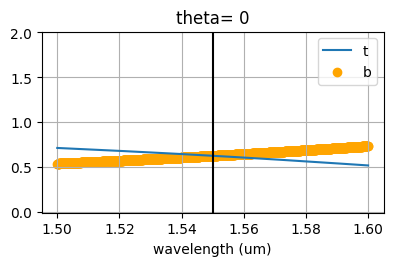

In [64]:
k=1
wl = np.linspace(1.5, 1.6, 1000)
ar=[0]
# , theta1=0.2,phi1=0.75,theta2=0.25,phi2=0.25

f=plt.figure()
f.set_figheight(8)
f.set_figwidth(15)
for i in ar:

    sim = ClassicalSim(ckt=coupl, wl=wl)
    laser_t = sim.add_laser(ports=["in1"], power=1)
    laser_b = sim.add_laser(ports=["in2"], power=0.25)
    detector_t = sim.add_detector(ports=["out1"])
    detector_b = sim.add_detector(ports=["out2"])
    result = sim.run()


 
    plt.subplot(3,3,k)
   
    plt.plot(wl, np.abs(result.sdict['out1'])**2, label='t')
    plt.scatter(wl, np.abs(result.sdict['out2'])**2, label='b',color='orange')
    plt.axvline(x=1.55, color='k')
    plt.legend()
    plt.grid()
    plt.title("theta= "+ str(i))
    plt.ylim([-0.01,2.01])
    plt.xlabel("wavelength (um)")
    k=k+1

In [63]:
coupl(wl=1.55)

{('in1', 'in1'): Array([0.+0.j], dtype=complex128),
 ('in1', 'in2'): Array([0.+0.j], dtype=complex128),
 ('in1', 'out1'): Array([0.53576894-0.46145669j], dtype=complex128),
 ('in1', 'out2'): Array([-0.46146533-0.53577898j], dtype=complex128),
 ('in2', 'in1'): Array([0.+0.j], dtype=complex128),
 ('in2', 'in2'): Array([0.+0.j], dtype=complex128),
 ('in2', 'out1'): Array([-0.46146533-0.53577898j], dtype=complex128),
 ('in2', 'out2'): Array([0.53576894-0.46145669j], dtype=complex128),
 ('out1', 'in1'): Array([0.53576894-0.46145669j], dtype=complex128),
 ('out1', 'in2'): Array([-0.46146533-0.53577898j], dtype=complex128),
 ('out1', 'out1'): Array([0.+0.j], dtype=complex128),
 ('out1', 'out2'): Array([0.+0.j], dtype=complex128),
 ('out2', 'in1'): Array([-0.46146533-0.53577898j], dtype=complex128),
 ('out2', 'in2'): Array([0.53576894-0.46145669j], dtype=complex128),
 ('out2', 'out1'): Array([0.+0.j], dtype=complex128),
 ('out2', 'out2'): Array([0.+0.j], dtype=complex128)}

In [9]:
from simphony.quantum import QuantumResult, QuantumSim,QuantumState,CoherentState,SqueezedState, compose_qstate
from simphony.quantum import plot_quantum_result
import thewalrus as tw
from simphony.quantum import SqueezedState
import random

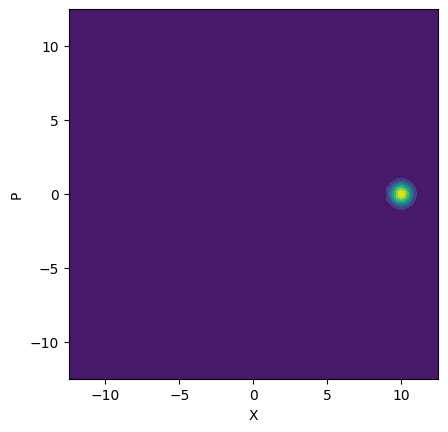

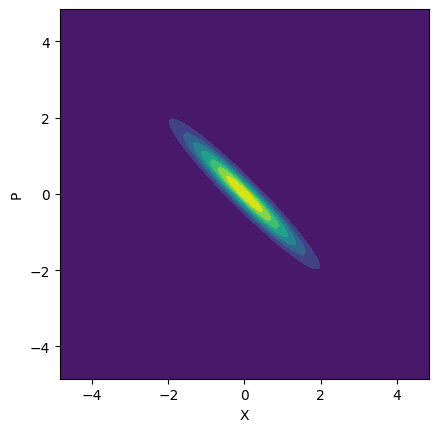

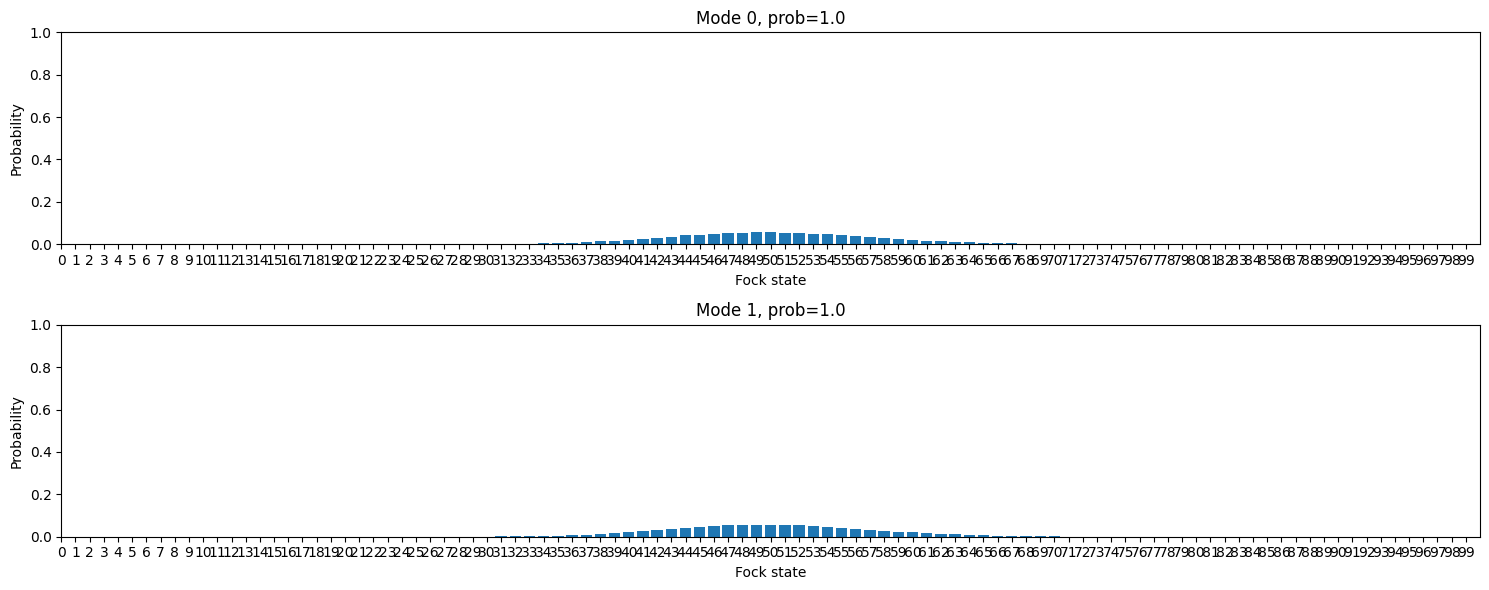

In [65]:

theta=[0.125,0.5,0.625]
theta=[0.125]
ang=0


for theta in theta:
    
# , theta1=0.25,phi1=0.5,theta2=0.25,phi2=0

    wl = 1.55 # um
    sim = QuantumSim(ckt=coupl,wl=wl)

    coh_alpha=10*np.exp(1j*2*np.pi*1)     
    qstate_2 =SqueezedState(port="in1",r=1,alpha=0*(1+1j),phi=4*np.pi*theta)
    qstate_1 = CoherentState(port="in2", alpha=coh_alpha)

    # qstate_2 = CoherentState(port="inb", alpha=1*(1+1j))(np.abs(np.exp(2*np.pi*theta).real))
    # qstate_1 =SqueezedState(port="int",r=1.5,alpha=3*(1+1j),phi=2*np.pi*theta)

    # qstate_2 =SqueezedState(port="in1",r=0.5,alpha=0*np.exp(1j*2*np.pi*theta),phi=4*np.pi*theta)

    # qstate=compose_qstate(qstate_1,qstate_2)
    sim.add_qstate(qstate=qstate_1)
    
    for t in range(1):
     qstate_1.plot_mode(mode=t)
    
    res = sim.run()

    qstate_2.plot_mode(mode=0)

#     plot_quantum_result(res, wl_ind=0, include_loss_modes=False)

# plt.figure(figsize=(15, 6))

    res_state = res.state()
    fig,ax=plt.subplots(2,1,figsize=(15,6))

    for i in range(0,2):
        means, cov = res_state.modes(i+2)
        fock_amp = tw.quantum.state_vector(means, cov, cutoff=100, hbar=1/2, check_purity=False)
        # ax=plt.subplot(2,2,i-1)

        prob=np.sum(abs(fock_amp)**2) 
        prob=round(prob,3)   
        pdf=np.array(abs(fock_amp)**2)
        ax[i].set_title(f'Mode {i}, prob={prob}')
        ax[i].bar(range(len(fock_amp)), abs(fock_amp)**2)
        ax[i].set_xticks(range(len(fock_amp)))
        ax[i].set_xlabel("Fock state")
        ax[i].set_ylabel("Probability")
        ax[i].set_ylim([0, 1])
        ax[i].set_xlim([0, 100])

    plt.tight_layout()
    plt.show()

In [11]:
max(np.abs(fock_amp))

0.2373288948872737

In [23]:
a=[]
theta_arr=np.linspace(0,1,9)
for t in theta_arr:
    a.append(t)
    

a

[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]

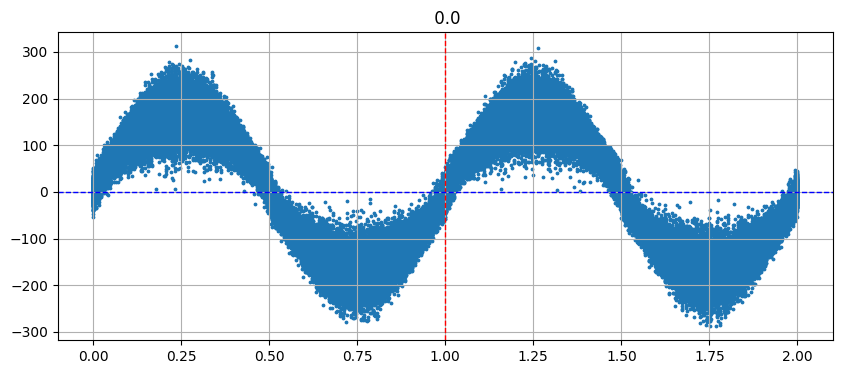

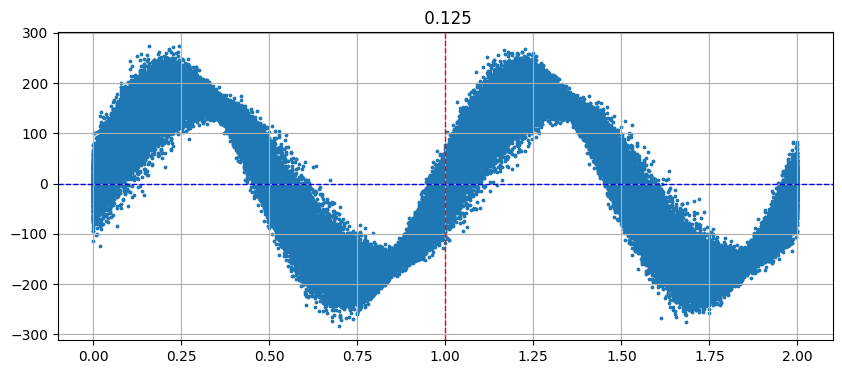

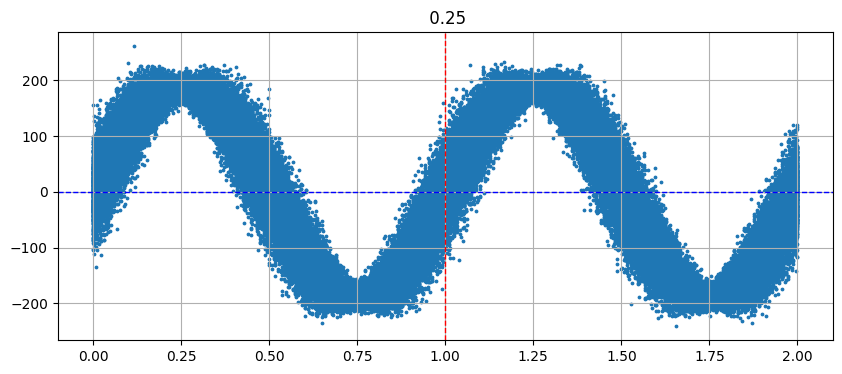

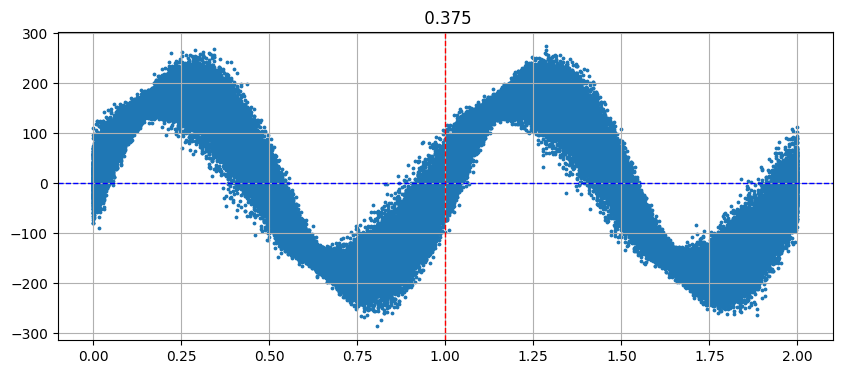

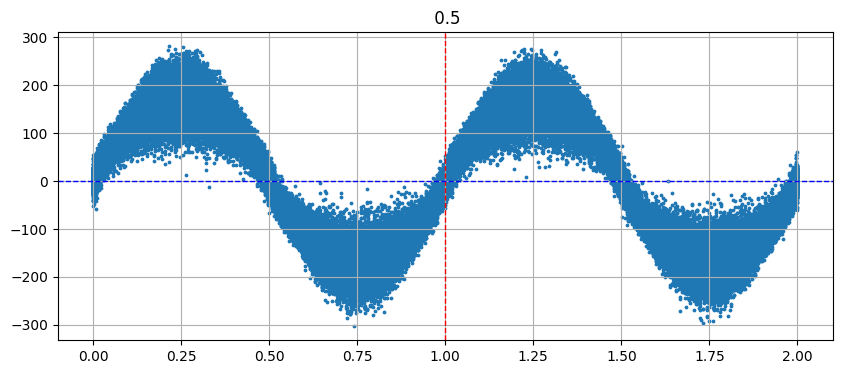

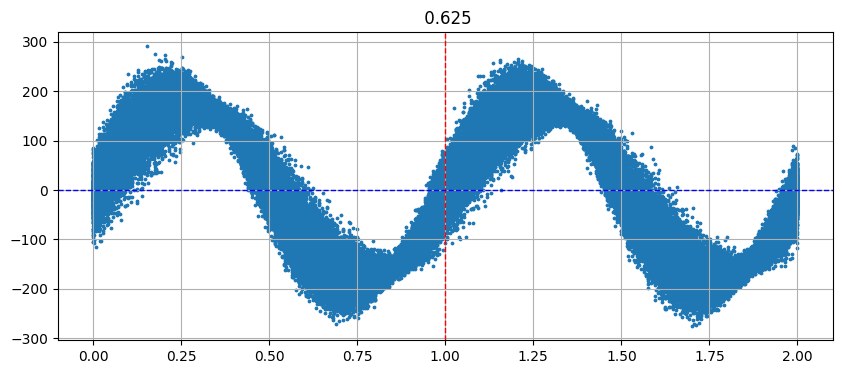

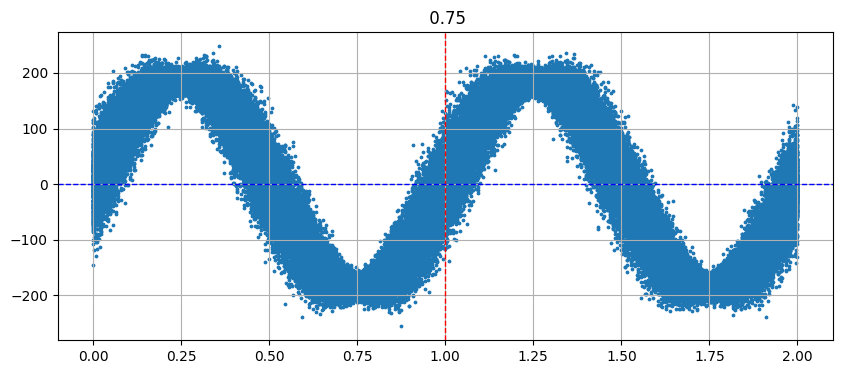

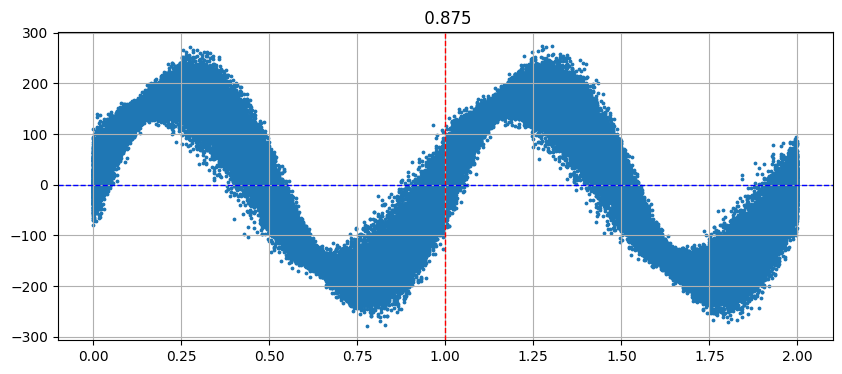

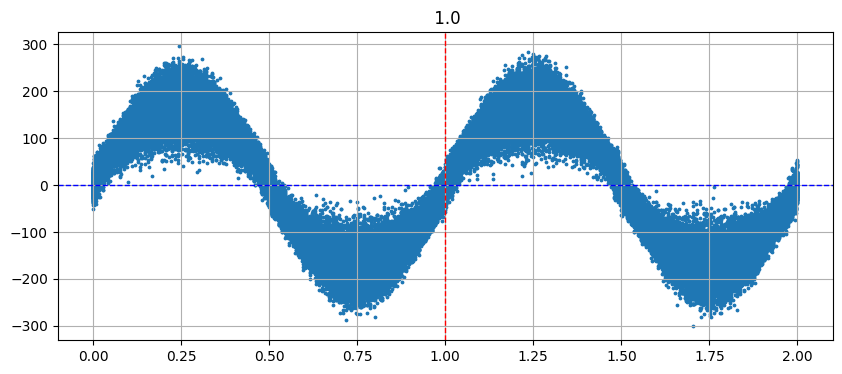

In [81]:

 

N=1 #no of times
# wl=np.linspace(1.5,1.6,1001)

# f=plt.figure()
# f.set_figheight(30)
# f.set_figwidth(15)
# k=1

Net_phi=np.linspace(0,2,500)
theta_arr=[0,0.125,0.25,0.3750,0.5,0.625,0.75,0.875]


theta_arr=np.linspace(0,1,9)
# theta_arr=[0.125,0.25,0.5]


# theta_arr=np.linspace(0,1,20)
# theta_arr=[0]



for theta in theta_arr:

    i1=[]
    i2=[]
    p1=[]
    p2=[]
    x=[]
    y=[]    
    f1=[]
    f2=[]

    for net_phi in Net_phi:
        p1=[]
        p2=[]
        f1=[]
        f2=[]        


        phi=theta+net_phi
        

        for n in range(N):   
            
             

# su2,wl=wl, theta1=0.75,phi1=0.25,theta2=0.75,phi2=0
            wl = 1.55 # um
            sim = QuantumSim(ckt=coupl,wl=wl)

            coh_alpha=30*np.exp(1j*2*np.pi*phi)     
            qstate_2 =SqueezedState(port="in1",r=1.5,alpha=5*np.exp(1j*2*np.pi*theta),phi=2*np.pi*0.5)
            qstate_1 = CoherentState(port="in2", alpha=coh_alpha)

            qstate=compose_qstate(qstate_1,qstate_2)
            sim.add_qstate(qstate=qstate)
            
            # for t in range(2):
            #     qstate.plot_mode(mode=t)
            
            res = sim.run()     

            res_state = res.state()

        for i in range(2,4):
            means, cov = res_state.modes(i)
            fock_amp = tw.quantum.state_vector(means, cov, cutoff=500, hbar=1/2, check_purity=False)
           
            prob=round(np.sum(abs(fock_amp)**2) ,3)
            pdf=np.array(abs(fock_amp)**2)
         

            if i ==2:
                p1.append(pdf)
                
            if i ==3:
                p2.append(pdf)
                
            
        p1=np.array(p1)
        p2=np.array(p2)

        p1 = p1 / np.sum(p1)  #normalize
        p2 = p2 / np.sum(p2)

        p1=p1.flatten()
        p2=p2.flatten()
        
        
        # random pts
        for num in range(300):
            i1 = np.random.choice(range(len(fock_amp)), p=p1)
            i2 = np.random.choice(range(len(fock_amp)), p=p2)

            # I=i1-i2
            I=np.subtract(i1,i2)
           
            f1.append(i1)
            f2.append(i2)
            y.append(I)
            x.append(net_phi)
            # f1.append(i1)
            # f2.append(i2)


    # x=np.multiply(x,2*np.pi)
    # plt.figure(figsize=(10,4))
    # plt.plot(x,f1)
    # plt.plot(x,f2)
    
    # y=y/np.sum(y)
    plt.figure(figsize=(10,4))
    plt.scatter(x,y,s=3)
    plt.grid(True)
    plt.axvline(x=1, color='r', linestyle='--', linewidth=1)
    plt.title(f' {theta}')
# # Add a horizontal line at y = 06
    plt.axhline(y=0, color='b', linestyle='--', linewidth=1)
    # plt.xlim([5,15])

In [14]:
net_phi
phi


2.5

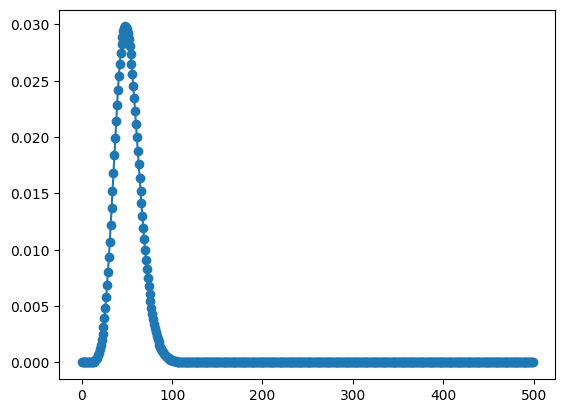

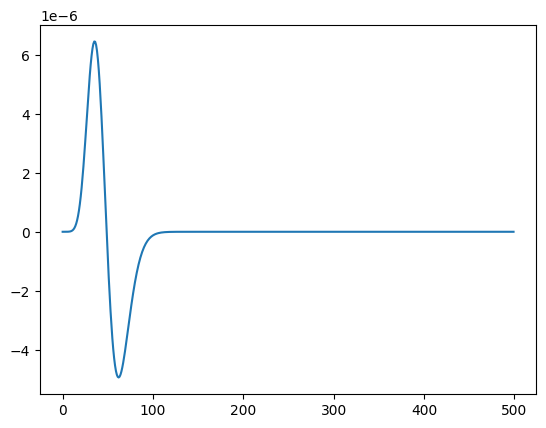

In [37]:
xx=range(len(p1))
f=plt.figure()
plt.plot(xx,p1)

# plt.plot(xx,p2)

plt.scatter(xx,p2)
fig=plt.figure()
plt.plot(xx,(p1-p2))

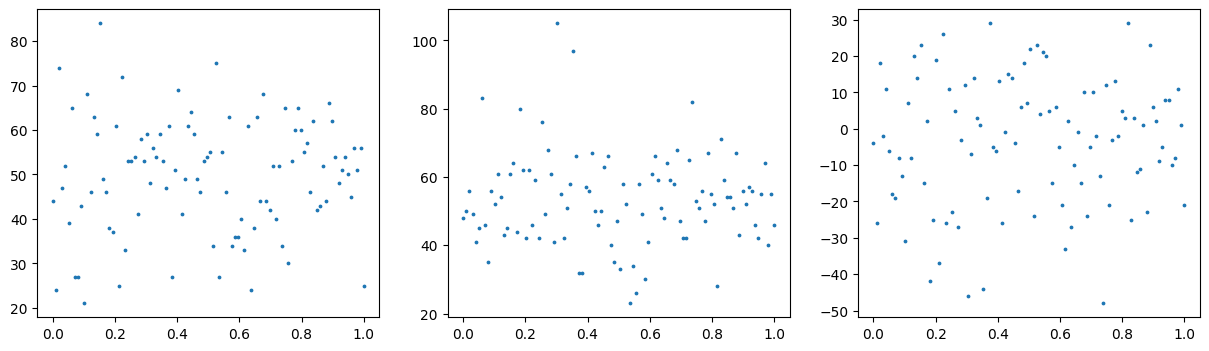

In [33]:

np.shape(x)
s=np.linspace(0,1,len(f1))
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(s,f1,s=3)
plt.subplot(1,3,2)
plt.scatter(s,f2,s=3)
d=np.subtract(f1,f2)
plt.subplot(1,3,3)
plt.scatter(s,d,s=3)

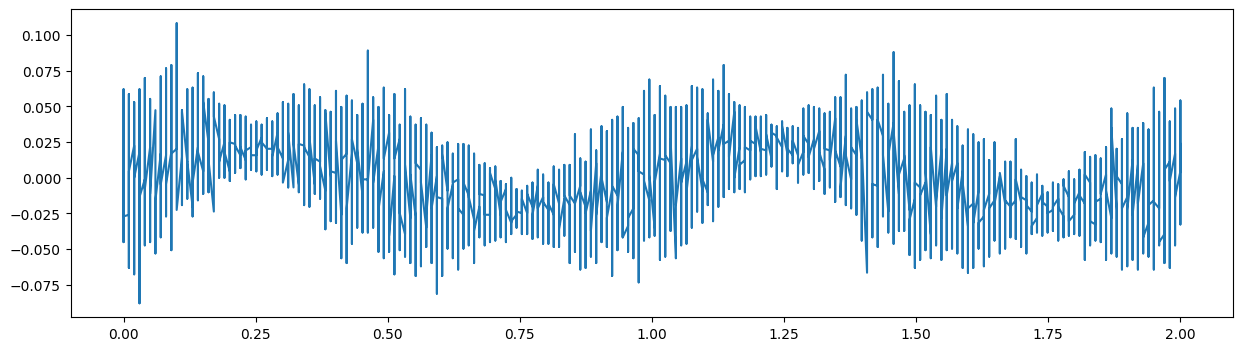

In [36]:
# x=np.multiply(x,(2*np.pi))
# y=y/np.sum(y)
plt.figure(figsize=(15,4))
# plt.scatter(x,y,s=3)
plt.plot(x,y)
# plt.grid(True)
# plt.axvline(x=0.5, color='r', linestyle='--', linewidth=1)

# # Add a horizontal line at y = 0
# plt.axhline(y=0, color='b', linestyle='--', linewidth=1)

# plt.xlim([5,15])

In [18]:
d1=[]
for u in range(1000):    
    
    e1 = np.random.choice(range(len(fock_amp)), p=p1)
    e2 = np.random.choice(range(len(fock_amp)), p=p2)

    I1=e1-e2
    d1.append(I1)

np.max(d1)

11

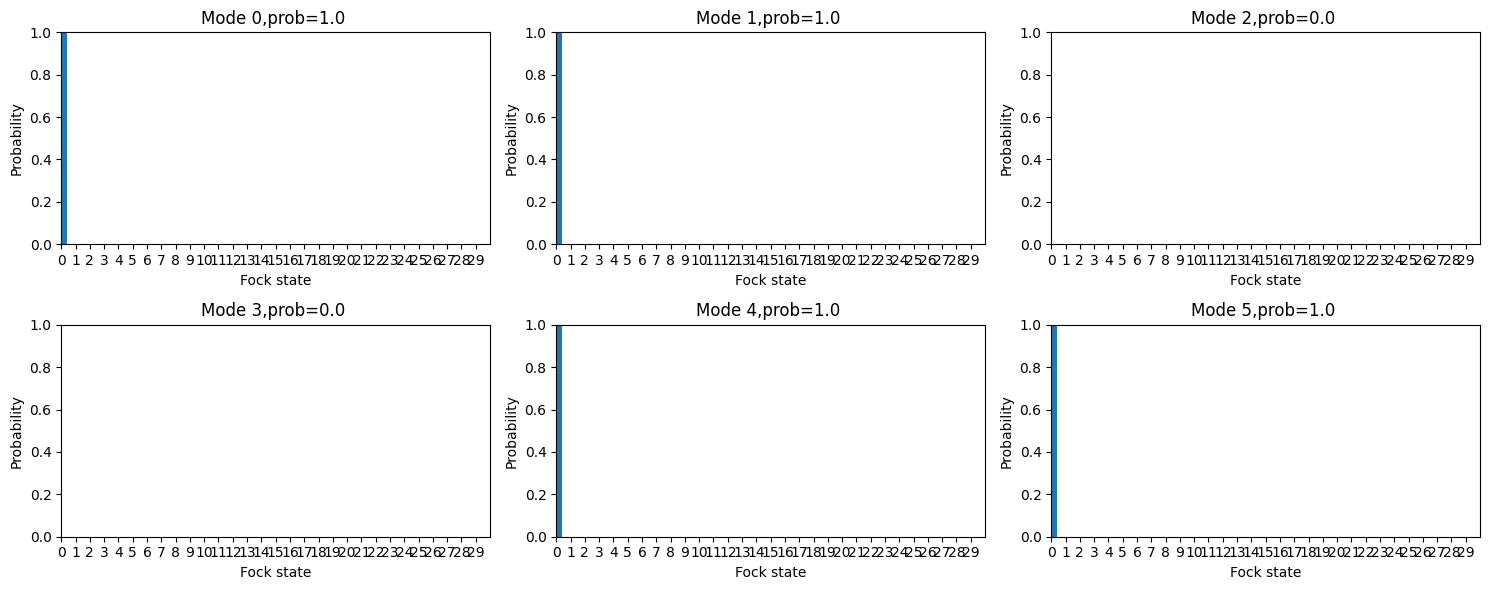

In [19]:
import thewalrus as tw
from simphony.quantum import SqueezedState

# f=plt.figure()
# f.set_figheight(6)
# f.set_figwidth(15)
f = plt.figure(figsize=(15, 6))

# wl = 1.55 # um
# sim = QuantumSim(ckt=su3,wl=wl,theta1=i1,phi1=j1,theta2=i2,phi2=j2,theta3=i3,phi3=j3)
# qstate = CoherentState(port="in1", alpha=(0)*(1+1j))
# qstate_1 = CoherentState(port="in2", alpha=(0.5)*(1+1j))
# qstate_2 = SqueezedState(port="in3", alpha=(0)*(1+1j),phi=0,r=0.5)
# # qstate = SqueezedState(port="in2", r=0.5,phi=np.pi*1,alpha=3*(1+1j))
# sim.add_qstate(qstate=qstate)
# sim.add_qstate(qstate=qstate_2)
# sim.add_qstate(qstate=qstate_1)
# res = sim.run()
res_state = res.state()

# fig, axes = plt.subplots(2,3)
# axes = axes.flatten()
for i in range(6):
    means, cov = res_state.modes(i)
    fock_amp = tw.quantum.state_vector(means, cov, cutoff=30, hbar=1/2, check_purity=False)
    ax=plt.subplot(2,3,i+1)

    prob=np.sum(abs(fock_amp)**2) 
    prob=round(prob,3)   
    ax.set_title(f'Mode {i},prob={prob} ')
    ax.bar(range(len(fock_amp)), abs(fock_amp)**2)
    ax.set_xticks(range(len(fock_amp)), range(len(fock_amp)))
    ax.set_xlabel("Fock state")
    ax.set_ylabel("Probability")
    ax.set_ylim([0,1])
    ax.set_xlim([0,30])

    
plt.tight_layout()
plt.show()